# Example of use of the Concurrent_neural_network package


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from Concurrent_Neural_Network.preprocessing import filter_index_from_dataframe, compute_proportion, add_temporal_features, dataframe_to_data_loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

## I Data

The data we use are 92400 weekly sales of 550 smartphones on CDiscount website. It has 5 columns:
 - product_id : the name of the product
 - monday_date : the monday of the week (week are taken from monday to sunday)
 - sales : number of sales of the week
 - price : average price of the week
 - margin : average relative margin of the week 


### I.A Reading Data 

In [2]:
CUR_DIR = os.getcwd()
DATA_FILE = os.path.join(CUR_DIR,'data','smartphone_data.csv' )

In [3]:
data =  pd.read_csv(DATA_FILE, sep =';')
data.set_index(['product_id', 'monday_date'], inplace= True)

### I.B Preprocess_data

We first use the function filter_index_from_dataframe to filter only the interesting products (with enough sales and enough data)

In [4]:
# filter parameters

minimal_sum=100 # A product must have at least minimal_sum to be considered
minimal_positive_length=15 # A product must have been sold during at least minimal_positive_length to be considered

In [5]:
filtered_data, products =  filter_index_from_dataframe(data, "sales", minimal_sum_target=minimal_sum, minimal_positive_length=minimal_positive_length )


In [6]:
print('Number of products before filter : %s' % len(set(data.index.get_level_values(0))) )
print('Number of products after filter : %s' % len(products) )
print('Number of sales before filter : %s' % sum(data['sales']))
print('Number of sales after filter : %s' % sum(filtered_data['sales']))
print('Keeped_sales_pourcentages: %.3f  ' %(100 * sum(filtered_data['sales'])/sum(data['sales'])) )

Number of products before filter : 1304
Number of products after filter : 1055
Number of sales before filter : 1434188.0
Number of sales after filter : 1403184.0
Keeped_sales_pourcentages: 97.838  


We then compute the market share of the products (we scale it to 100) :

In [11]:
market_shares, weekly_global_sales, products = compute_proportion(filtered_data, 'sales', resize=1)

### I.C Exploration of the sales data

Here we present some visualisations of the data

In [7]:
# temporal feature manipulation

def format_time_index(df, index_col_name):
    adf = df.reset_index()
    adf[index_col_name] = adf[index_col_name].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
    return adf.set_index(index_col_name)


In [8]:
f_weekly_global_sales = format_time_index(weekly_global_sales, 'monday_date')
f_weekly_total_sales  = format_time_index(data['sales'].groupby(level=1).sum(),'monday_date')

NameError: name 'weekly_global_sales' is not defined

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(f_weekly_global_sales, label = 'Selected_sales')
plt.plot(f_weekly_total_sales, label = 'Total_sales')
plt.legend()
plt.show()

There is a decreasing trend. It is caused by the way the products are selected. We will therefore ignore the last week.

## II Learning

### II.A Data Learning Setting

In [15]:
#parameters
horizon = 6 #Prediction horizon
features = ['proportion_shift_6', 'proportion_shift_7','price', 'margin'] # Here are the features used for prediction
target ='proportion'
n_input = len(features)

In [16]:
data_restrained = add_temporal_features(market_shares, horizon=horizon)
data_restrained['price'] = data_restrained['price'] /100
data_restrained.head()

<ipython-input-16-70ae8a21596b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_restrained['price'] = data_restrained['price'] /100


sales   price    margin  sales_somme  proportion  \
product         monday_date                                                     
SAMGALAXYA10NBL 2019-10-07   177.0  1.4999  1.168630      12680.0    0.013959   
                2019-10-14   118.0  1.4999  0.029735       8339.0    0.014150   
                2019-10-21   128.0  1.4999  0.029735       8211.0    0.015589   
                2019-10-28   177.0  1.4999  0.029735       6747.0    0.026234   
                2019-11-04   300.0  1.4999  0.029735       8775.0    0.034188   

                             proportion_shift_6  proportion_shift_7  
product         monday_date                                          
SAMGALAXYA10NBL 2019-10-07             0.006957            0.000212  
                2019-10-14             0.012555            0.006957  
                2019-10-21             0.016180            0.012555  
                2019-10-28             0.022547            0.016180  
                2019-11-04             0.008244            0.022547

In [17]:
date_learning =  '2020-06-01' # This date separate learning & testing set
date_stop = '2021_01_01' # This is the end of the testing set
X_train, X_test = data_restrained[data_restrained.index.get_level_values(1) < date_learning ], data_restrained[data_restrained.index.get_level_values(1) >= date_learning ]
X_test = X_test[X_test.index.get_level_values(1) < date_stop]

In [18]:
data_train_loader = dataframe_to_data_loader(X_train,features,target) 
data_test_loader = dataframe_to_data_loader(X_test,features,target) 

Now we present the prediction MAPE of some simple predictor :

    - null : 0
    - simple shift : predicting X_{t-h} for X_t
    - shifted 2-mean :  predicting (X_{t-h}+X_{t-h-1})/2  for X_t

Note that due to the scaling factor present on the Concurrent Neural network model they are not strictly equivalent, due to the arrival of new products. It gives however an reference

In [19]:
#Some reference_MAPE
print('Null MAPE %.2f' %   (100*sum(abs(  X_test['proportion']))/ sum(X_test['proportion'])))
print('Simple_shift MAPE %.2f' %   (100  *sum(abs(X_test['proportion_shift_6'] - X_test['proportion']))/ sum(X_test['proportion'])))
print('Simple 2-mean MAPE %.2f' %  (100  *sum(abs(X_test['proportion_shift_6']/2 + X_test['proportion_shift_7']/2 - X_test['proportion']))/ sum(X_test['proportion'])))

Null MAPE 100.00
Simple_shift MAPE 88.65
Simple 2-mean MAPE 86.96


### II.B Inner Neural Network model

Here we define the inner submodel we will use to compute the "competitiveness function". We stay simple and use a 2 layered neural network

In [28]:
class Feed_forward_model(nn.Module):
    "2 layers neural network used for for testing"

    def __init__(self, n_input, n_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(n_input, n_hidden, bias=False)
        self.linear_2 = nn.Linear(n_hidden, 1, bias=False)
        self.n_input = n_input
        self.n_hidden = n_hidden

    def forward(self, x):
        return F.softplus(self.linear_2(F.relu(self.linear_1(x))), )

n_hidden = 4
submodel = Feed_forward_model(n_input,n_hidden)

### II.C Concurrent neural network

Here is an example using a Concurrent neural network defined in the previous session 

Note: sometimes learning doesn't work, as the prediction stay constant. In this case, you should recompile both this and previous section (this is due to a bad inialisation of the submodel).

In [29]:
from Concurrent_Neural_Network.models import Concurrent_Module

learning_rate = 0.005
epochs = 200
model= Concurrent_Module(submodel, sum_factor=1, loss='L1', learning_rate =learning_rate)

In [30]:
model.train(data_train_loader,eval_dataset=data_test_loader, max_epochs=epochs, batch_print = epochs//10)

Epoch 0
Train MAPE: 133.7591
Test MAPE: 120.7434 

Epoch 20
Train MAPE: 95.8357
Test MAPE: 87.9909 

Epoch 40
Train MAPE: 91.4303
Test MAPE: 83.2091 

Epoch 60
Train MAPE: 89.9918
Test MAPE: 82.3293 

Epoch 80
Train MAPE: 89.7786
Test MAPE: 82.6094 

Epoch 100
Train MAPE: 89.4753
Test MAPE: 82.2045 

Epoch 120
Train MAPE: 89.4623
Test MAPE: 82.8056 

Epoch 140
Train MAPE: 89.4397
Test MAPE: 84.1233 

Epoch 160
Train MAPE: 89.1585
Test MAPE: 83.5027 

Epoch 180
Train MAPE: 89.1718
Test MAPE: 82.6605 



Concurrent Model MAPE 

In [31]:
_ = model.eval(data_test_loader)

Test MAPE: 82.0284 



## III Analysis of the model

We show in this section how to use the model we present in the last parts

### II.A Retrieving results from the model :


In this section, an example of output is provided and the prediction plotted. We first need some function to retrieve the comportement for a unique product

In [34]:
def data_to_position_dict(data, prod):
    date_index = list(set(data.index.get_level_values(1)))#List of the date existing in the dataset
    date_index.sort()
    dict_index_prod = dict()
    for i,dt in enumerate(date_index):
        sub_data = data[data.index.get_level_values(1) == dt]
        l_prod_dt = list(sub_data.index.get_level_values(0))
        if prod in l_prod_dt:
            dict_index_prod[i] = l_prod_dt.index(prod)
    return dict_index_prod

def get_prediction_series(model, dict_index_prod):
    l_prevs = []
    for key in dict_index_prod.keys():
        l_prevs.append(float(model(data_test_loader[key][0])[dict_index_prod[key]]))
    return l_prevs
    

In [35]:
prod = 'HUAWPSMART64BLEU' # The product sales and prediction we want to plot

In [36]:
dict_index_prod = data_to_position_dict(X_test, prod)
sales_product_series = X_test.loc[prod]['proportion']
pred_product_series = pd.Series( data = get_prediction_series(model, dict_index_prod), index = sales_product_series.index)


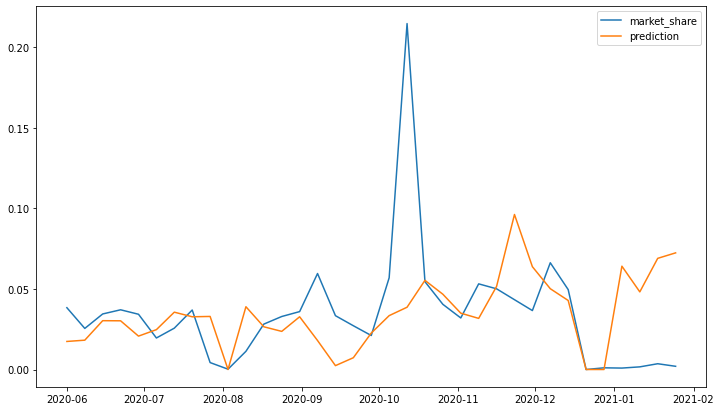

In [37]:
plt.figure(figsize=(12,7))
plt.plot(format_time_index(sales_product_series, 'monday_date'), label ='market_share')
plt.plot(format_time_index(pred_product_series, 'monday_date'), label ='prediction')
plt.legend()
plt.show()

Remember : it is a 6 week in advance prediction

### II.B Covariates influence

In this section, we compile partial dependance of the competitivity of the submodel

In [40]:
# Let's recall the feature we use :
features

['proportion_shift_6', 'proportion_shift_7', 'price', 'margin']

In [94]:
selected_features = "margin"
bins = 70

In [97]:
_, selected_fet_bin = pd.qcut(X_train[selected_features], bins, duplicates='drop', retbins=True)
avg_imp = []
lis_x = []
for j,b in  enumerate(selected_fet_bin[:-1]):
    X_test_rep = X_test.copy()
    X_test_rep[selected_features] = (b+selected_fet_bin[j+1])/2
    lis_x.append((b+selected_fet_bin[j+1])/2)
    tt_enter =torch.tensor(X_test_rep[features].values.astype(np.float32)) 
    comp = submodel(tt_enter)
    avg_imp.append(sum(comp)/len(comp))

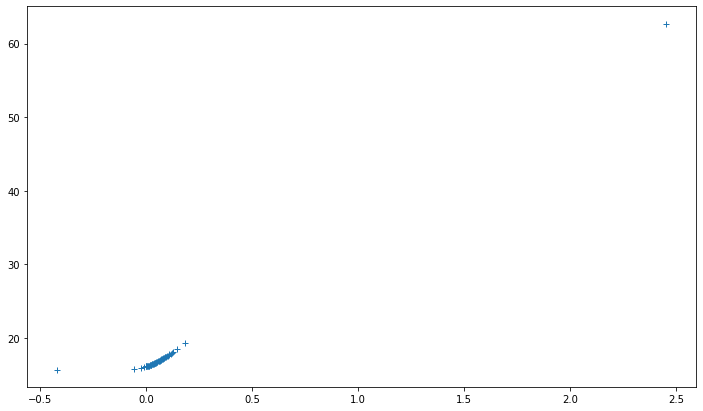

In [98]:
plt.figure(figsize=(12, 7))
plt.plot( lis_x, avg_imp, '+')
#plt.xscale('log')
#plt.yscale('log')

weird